In [1]:
# Installing Libraries


! pip install transformers -q
! pip install annoy -q

     |████████████████████████████████| 2.6 MB 6.5 MB/s 
     |████████████████████████████████| 3.3 MB 41.5 MB/s 
     |████████████████████████████████| 636 kB 55.0 MB/s 
     |████████████████████████████████| 895 kB 74.4 MB/s 
     |████████████████████████████████| 646 kB 8.5 MB/s 


In [2]:
# Importing Libraries


from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
import string
import re

from tqdm.auto import tqdm
tqdm.pandas()

import _pickle as cPickle

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# Checking to see if CUDA is available if so storing details in device


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


#Mean Pooling - Take attention mask into account for correct averaging


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Function to generate embeddings


def get_embedings(model,sentences,max_seq_len):
  model.to(device)   ##to run on gpu
  sent_len=len(sentences)
  limit=50
  if sent_len>limit:
    sentence_embeddings=[]
    for i in range(0,sent_len,limit):
      j=i+limit
      if j>sent_len:
        j=sent_len
      #Tokenize sentences   Here tokenize and genrtae sentence embeddings in 10000 chunk 
      encoded_input = tokenizer(sentences[i:j], padding=True, truncation=True, max_length=max_seq_len, return_tensors='pt')
      encoded_input.to(device)
      #Compute token embeddings
      with torch.no_grad():
          model_output = model(**encoded_input)
      #Perform pooling. In this case, mean pooling
      sentence_embeddings1 = mean_pooling(model_output, encoded_input['attention_mask'])
      sentence_embeddings = sentence_embeddings+sentence_embeddings1.tolist()
  else :
      encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=max_seq_len, return_tensors='pt')
      encoded_input.to(device)
      #Compute token embeddings
      with torch.no_grad():
          model_output = model(**encoded_input)
      #Perform pooling. In this case, mean pooling
      sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
      sentence_embeddings = sentence_embeddings.tolist()
  print(len(sentence_embeddings))
  return sentence_embeddings

In [4]:
# Mounting Google drive


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# dffake = pd.read_csv("/content/drive/Shareddrives/FYP - knk/Datasets/FakeNewsNet/politifact_fake.csv")
# dftrue = pd.read_csv("/content/drive/Shareddrives/FYP - knk/Datasets/FakeNewsNet/politifact_real.csv")
# dftrue.info()
# dftrue["label"] = 0
# dffake["label"] = 1
# df_1 = dftrue.append(dffake,ignore_index = True)
# # df.drop(["id","news_url","tweet_ids"],axis=1 , inplace=True)

# df_fake = pd.read_csv("/content/drive/Shareddrives/FYP - knk/Datasets/FakeNewsNet/gossipcop_fake.csv")
# df_true = pd.read_csv("/content/drive/Shareddrives/FYP - knk/Datasets/FakeNewsNet/gossipcop_real.csv")
# df_true["label"] = 0
# df_fake["label"] = 1
# df_2=df_true.append(df_fake,ignore_index = True)

# df=df_1.append(df_2,ignore_index = True)

# df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df_fake = pd.read_csv("/content/drive/Shareddrives/FYP - knk/Datasets/ISOT/Fake.csv")
df_true = pd.read_csv("/content/drive/Shareddrives/FYP - knk/Datasets/ISOT/True.csv")
df_true["label"]=0
df_fake["label"]=1
df=df_true.append(df_fake,ignore_index = True)
df.drop(["subject","date"],axis=1 , inplace=True)
df = df.sample(frac=1).reset_index(drop=True)
print(df_true.info())
print(df_fake.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB
None


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [8]:
df = df.dropna(subset = ['text'], how='all')

In [9]:
# Remove Duplicates

duplicate_count = len(df['text'])-len(df['text'].drop_duplicates())
print('Duplicate count:', duplicate_count)
print('Total records before remove duplicates:', df.shape[0])

# drop duplicates (keep the last post of each of the duplicates)

df = df.drop_duplicates(subset='text', keep="first")
print('updated record count:', df.shape[0])

Duplicate count: 6252
Total records before remove duplicates: 44898
updated record count: 38646


In [10]:
import string
import re

def lower(text):
  return text.lower()

# remove urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_nonascii(sent):
  return "".join([i for i in sent if i.isascii()])

def remove_punctuations(text):
  # text = text.translate(str.maketrans('', ' ', string.punctuation))
  # return text

  res = re.sub(r'[^\w\s]', ' ', text)
  return res

def remove_num(text):
  return "".join([c for c in text if not c.isdigit()])

# remove multiple spaces
def remove_mul_space(text):
  return " ".join(text.split())

def clean(text):
  text = lower(text)
  text = remove_urls(text)
  text = remove_nonascii(text)
  text = remove_punctuations(text)
  text = remove_num(text)
  text = remove_mul_space(text)
  return text

In [11]:
df['text'] = df['text'].apply(clean)

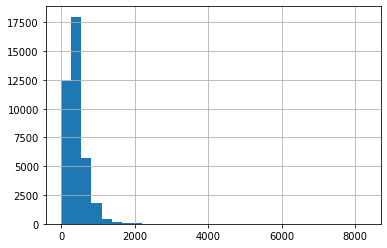

In [12]:
texts = df['text'].tolist()

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in texts]

pd.Series(seq_len).hist(bins = 30)

In [13]:
max_seq_len = 500

In [14]:
# Defining the model here, we use a model that is fine tuned on News articles
model_name = "textattack/roberta-base-ag-news"
# model_name = "roberta-large"

# Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at textattack/roberta-base-ag-news were not used when initializing RobertaModel: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# Generate Embeddings
title_embeddings = get_embedings(model, texts, max_seq_len)

38646


In [16]:
with open(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/df_word_embedding.pickle", "rb") as input_file:
  data = cPickle.load(input_file)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   word       318 non-null    object
 1   label      318 non-null    int64 
 2   embedding  318 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.6+ KB


In [18]:
from annoy import AnnoyIndex

f = 768
t = AnnoyIndex(f, 'dot')  # Length of item vector that will be indexed

t.load(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/embedding_space.ann")

True

In [19]:
r = []
for i in range (len(title_embeddings)):
  result = t.get_nns_by_vector(title_embeddings[i], 75, include_distances=True)
  true_score, fake_score = 0, 0

  for i in range(30):

    if data['label'][result[0][i]] == 1:

      fake_score += result[1][i]
      # fake_score += 1
    else:

      true_score += result[1][i]
      # true_score += 1
      
  # for item in result:
  #   if data['label'][item[1]] == 1:
  #     fake_score += item[0]
  #   else:
  #     true_score += item[0]

  if fake_score<true_score:
    r.append(0)
  else:
    r.append(1)

In [20]:
act_labels = df['label'].tolist()

from sklearn.metrics import classification_report

print(classification_report(act_labels, r))

              precision    recall  f1-score   support

           0       0.52      0.79      0.63     21191
           1       0.31      0.12      0.17     17455

    accuracy                           0.48     38646
   macro avg       0.41      0.45      0.40     38646
weighted avg       0.42      0.48      0.42     38646



In [21]:
from sklearn.metrics import confusion_matrix

# confusion matrix
matrix = confusion_matrix(act_labels,r, labels=[1,0])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[ 2043 15412]
 [ 4552 16639]]
